In [17]:
# importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import os, sys

In [18]:
# importing data
df = pd.read_csv('../2.Downloading data/processed_high_impact_outages.csv', parse_dates=['Start', 'Finish'])
df = df.replace({r"\r|\n": " "}, regex=True)
df.columns = df.columns.str.replace(r'[\r\n]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
df = df.drop(columns=['Status_Description_Market', 'Market_Notice_Code'])

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18714 entries, 0 to 18713
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Region              18714 non-null  object        
 1   NSP                 18714 non-null  object        
 2   Start               18504 non-null  datetime64[ns]
 3   Finish              18504 non-null  datetime64[ns]
 4   Network Asset       18714 non-null  object        
 5   Recall_Day_Hours    18714 non-null  float64       
 6   Recall_Night_Hours  18714 non-null  float64       
 7   Project Work?       18714 non-null  int64         
 8   Unplanned?          18714 non-null  int64         
 9   DNSP Aware?         18714 non-null  int64         
 10  Generator Aware?    18714 non-null  int64         
 11  Inter-Regional      18714 non-null  int64         
 12  Status_Description  18707 non-null  object        
 13  Status_Code         17963 non-null  object    

,Region,NSP,Start,Finish,Network Asset,Recall_Day_Hours,Recall_Night_Hours,Project Work?,Unplanned?,DNSP Aware?,Generator Aware?,Inter-Regional,Status_Description,Status_Code,Impact_Region,Reason,Duration_Hours,Impact,file_name
0,NSW,Transgrid,2021-08-30 06:05:00,2021-09-01 12:00:00,Armidale - Dumaresq (8C) 330 kV Line,3.0,4.0,0,0,0,0,1,In Progress,PTP,NSW,Commissioning,52.8,<<UPDATED since the last notification>> A cre...,2021-08-30
1,QLD,Powerlink,2021-09-01 08:30:00,2021-09-01 12:00:00,Ross No.4 288/138/19 kV Transformer,1.0,0.0,0,0,1,0,0,Planned,MTLTP,QLD,Maintenance,3.5,This is a high impact outage because the recal...,2021-08-30
2,NSW,Transgrid,2021-09-04 06:00:00,2021-09-05 17:00:00,Liddell to Muswellbrook (83) 330 kV Line,4.0,4.0,0,0,1,0,1,Planned,MTLTP,NSW,Commissioning,36.0,A credible contingency event during this plann...,2021-08-30
3,SA,ElectraNet,2021-09-06 08:00:00,2021-09-12 08:15:00,Heywood - South East No.1 275 kV Line,159.0,159.0,0,0,0,0,1,Planned,SUBMIT,SA,Commissioning,144.0,<<NEW since the last notification>> A credibl...,2021-08-30
4,QLD,Powerlink,2021-09-06 08:30:00,2021-09-10 16:00:00,Ross No.3 288/138/19 kV Transformer,4.0,6.0,0,0,1,0,0,Planned,MTLTP,QLD,Maintenance,103.2,This is a high impact outage because the recal...,2021-08-30


In [19]:
df['Region'].value_counts()

Region
VIC         10099
QLD          3932
SA           2541
NSW          1122
TAS          1019
VIC/ TAS        1
Name: count, dtype: int64

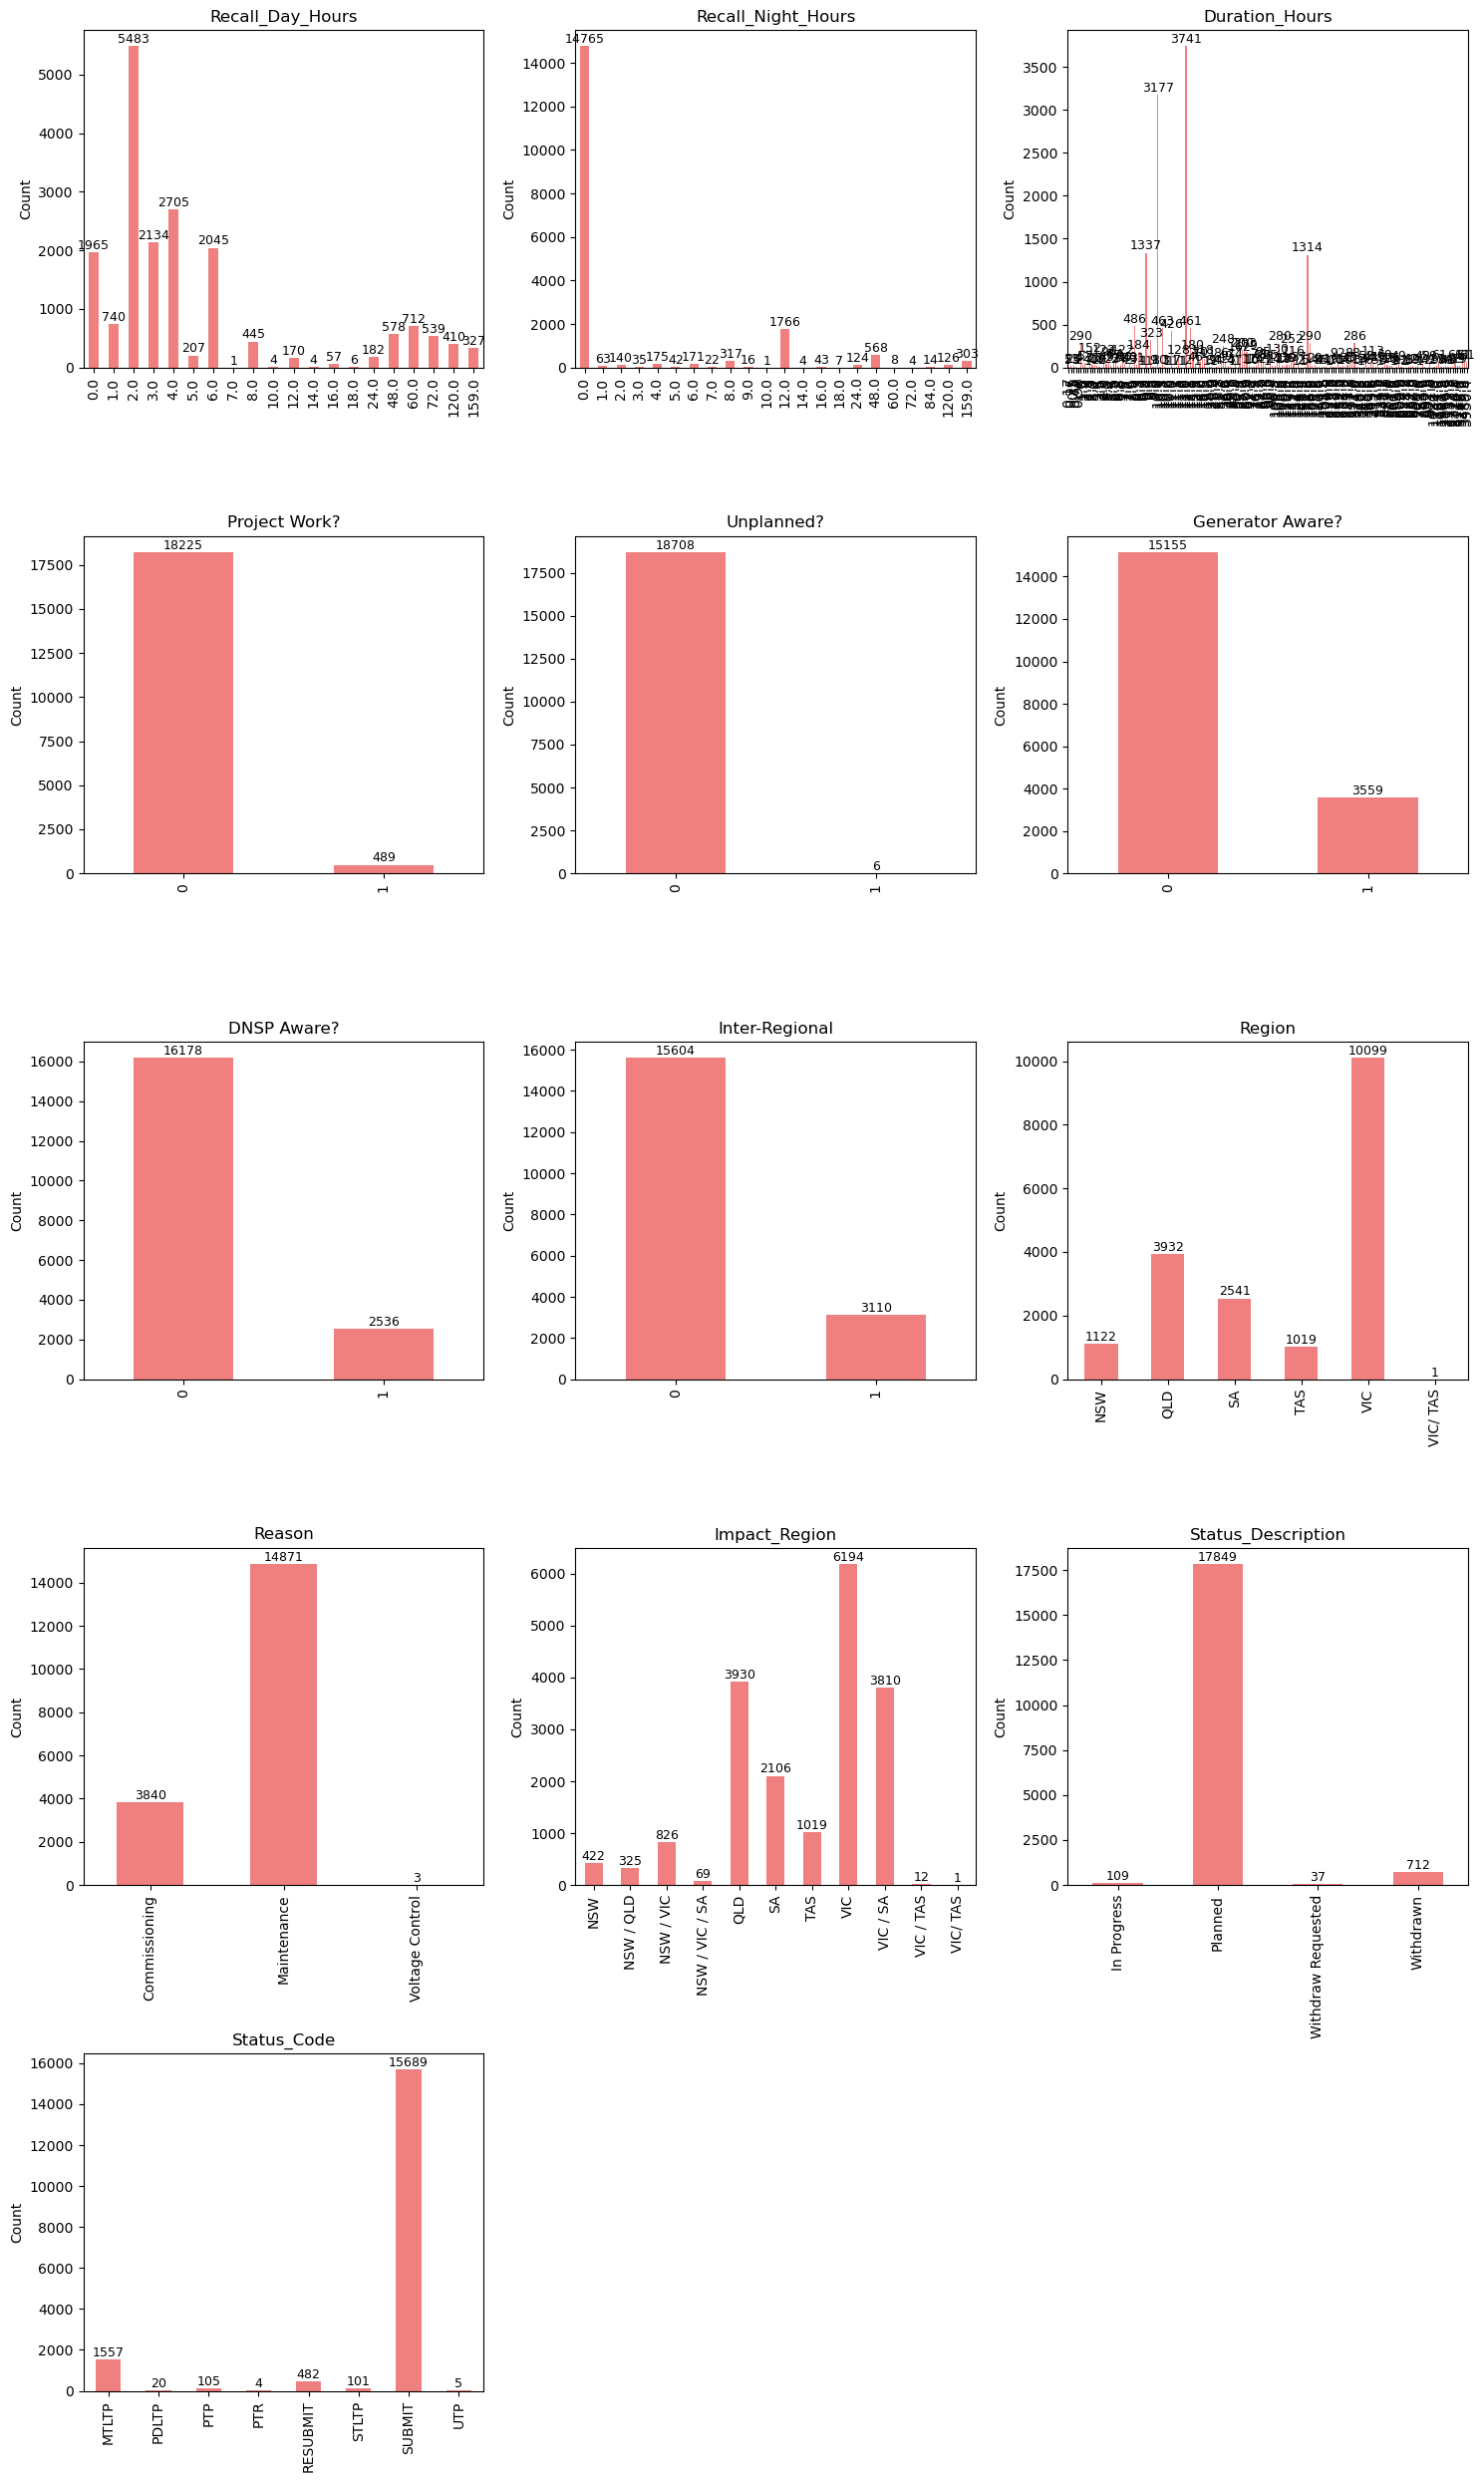

In [20]:
bool_cols = ['Project Work?', 'Unplanned?', 'Generator Aware?', 'DNSP Aware?', 'Inter-Regional']
numeric_cols = ['Recall_Day_Hours', 'Recall_Night_Hours']
categorical_cols = ['Region', 'Reason', 'Impact_Region', 'Status_Description', 'Status_Code']

# Combine all into one list
all_cols = numeric_cols + bool_cols + categorical_cols

n_cols = 3  # number of columns per row
n_rows = (len(all_cols) + n_cols - 1) // n_cols  # compute required rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(all_cols):
    ax = axes[idx]

    # Value counts for categorical/boolean/numeric columns
    counts = df[col].value_counts().sort_index()

    # # Limit too many bars for high-cardinality categories (optional)
    # if len(counts) > 20:
    #     counts = counts.head(20)
    #     ax.set_title(f"{col} (Top 20)")

    # Plot bar chart
    counts.plot(kind='bar', ax=ax, color='lightcoral')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

    # Add value labels on bars
    for i, value in enumerate(counts):
        ax.text(i, value + 1, str(int(value)), ha='center', va='bottom', fontsize=9, rotation=0)

# Remove any unused subplots
for j in range(len(all_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

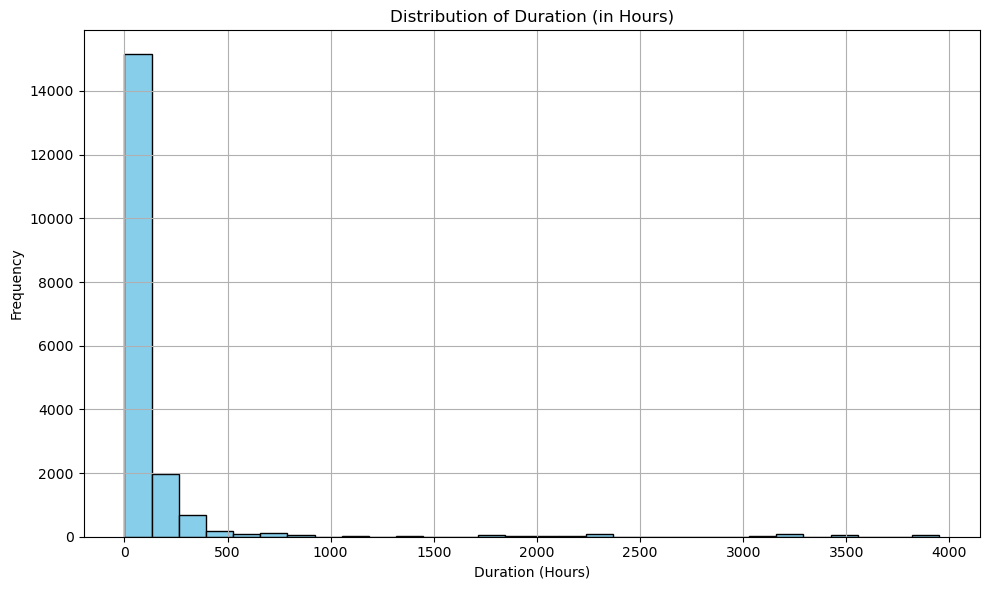

In [21]:
import matplotlib.pyplot as plt

# Drop NaNs to avoid issues in plotting
duration_data = df["Duration_Hours"].dropna()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_data, bins=30, edgecolor='black', color='skyblue')
plt.title("Distribution of Duration (in Hours)")
plt.xlabel("Duration (Hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


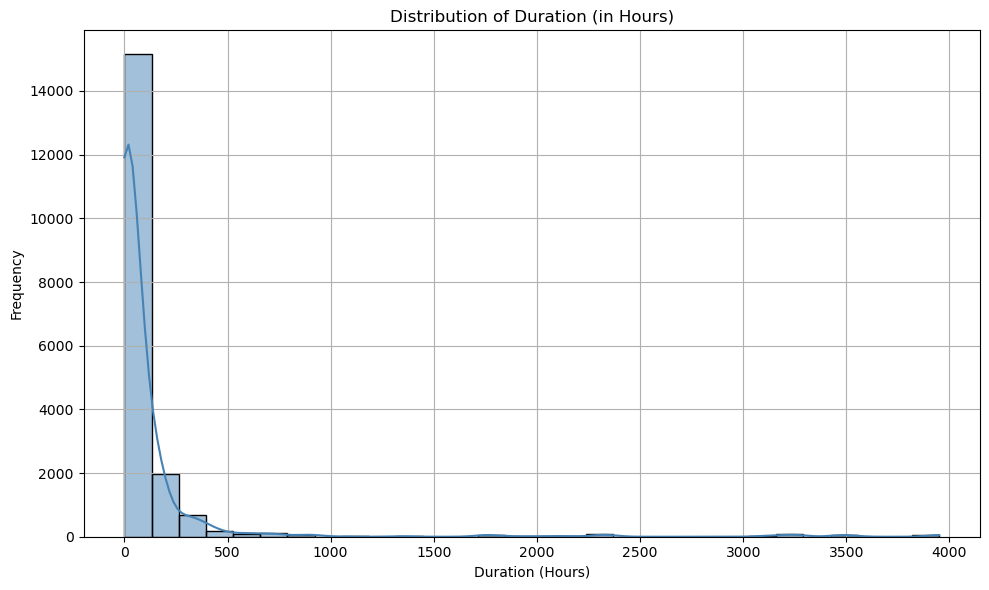

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop NaNs
duration_data = df["Duration_Hours"].dropna()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(duration_data, bins=30, kde=True, color='steelblue')
plt.title("Distribution of Duration (in Hours)")
plt.xlabel("Duration (Hours)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()